# Классификация и градиентные спуски

В этой тетрадке мы попробуем немного посмотреть на то, как работают разные градиентные спуски. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings       
warnings.filterwarnings("ignore") 

plt.style.use('ggplot')
%matplotlib inline

In [ ]:
# FOR GOOGLE COLAB TO GET DATA
# !git clone https://github.com/rsuh-python/mag2023NN.git
# %cd /content/mag2023NN/02-GradActivNormReg

# 1. Выборка

Делать всё это мы будем на животных. Ежегодно около 7.6 миллионов бедных животных в США оказываются в приютах. Часть из них находит себе новую семью, часть возвращается к старому (бывает, что питомец потерялся и его нашли на улице), а часть погибает. Ежегодно усыпляется около 2.7 млн. собак и кошек.  

Используя датасет с входной информацией (цвет, пол, возраст и т.п.) из одного из приютов, мы попытаемся спрогнозировать что произойдёт с новыми животными, которые попадут в этот приют. Данные, используемые в тетрадке, уже были предварительно обработаны и приведены в удобную для построения моделей форму. 

In [2]:
X = pd.read_csv('./data/X_cat.csv', sep='\t', index_col=0)
target = pd.read_csv('./data/y_cat.csv', sep='\t', index_col=0, names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


В датасете находится около 27 тысяч наблюдений и 39 регрессоров. Посмотрим на то, как выглядит распределение того, что произошло со зверятами по особям.

In [3]:
target.status.value_counts()

status
Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: count, dtype: int64

Видим, что классы несбалансированы. Попробуем оставить четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [3]:
target = target.values
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [4]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(target)
y

array([2, 1, 0, ..., 0, 3, 3])

In [6]:
len(y)

26729

In [7]:
X.shape

(26729, 37)

Разобьём выборку на тренировочную и тестовую. 

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(X_train.shape)
print(X_test.shape)

(21383, 37)
(5346, 37)


In [6]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# 2. Архитектурка

In [7]:
import torch
import torch.nn as nn            # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F  # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

Функция для рисования графиков

In [8]:
def plot(histories):
    plt.figure(figsize=(16,10))
    
    for name, val_loss in histories:
        plt.plot(val_loss, label=name)

    plt.legend()

 Соберем архитектуру модели

In [9]:
INPUT_SIZE = 37
HIDDEN_SIZE = 25
OUTPUT_SIZE = 4
BATCH_SIZE = 1000
EPOCHS = 100
LEARNING_RATE = 0.001

class MyModel(nn.Module):
    def __init__(self):
        """тут мы просто объявляем, какие нам нужны слои, 
        и сохраняем их в динамических атрибутах"""
        super().__init__()
        self.fc1 = nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE)
        self.fc2 = nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE)
        self.out = nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE)



    def forward(self, x):
        """Этот метод будет вызываться невидимо для нас, 
        когда мы передаем в модель данные (подумаем про __call__...)"""
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = nn.Softmax()(self.out(x))
        return x

Напишем функцию, которая будет тренировать нейронную сеть. Функция имеет 2 логические части: первая - тренировочная, вторая - валидационная, другими словами, та, на которой вычисляется ошибка и сравнивается с ошибкой на тренировочных данных

In [10]:
def run_train(model, optimizer, criterion, scheduler=None):
    train_loss_values = []
    train_accuracy_values = []
    valid_loss_values = []
    valid_accuracy = []
    lr_history = []

    model.train()
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()
            
            # run model on the chosen batch
            output = model(features)

            # Calculate error and backpropagate
            label = label.long()
            loss = criterion(output, label)
            loss.backward()

            # manual accuracy calculation; no torch lightning
            acc = (output.argmax(dim=1)==label).sum() / len(label)

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)


        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d,  train_loss: %f, valid_accuracy: %f' % (epoch, train_loss_values[-1], train_accuracy_values[-1]))


        model.eval()
        # Run validation
        running_loss = []
        running_acc = []
        with torch.no_grad(): # in validation loop we do not need gradients calculation; so switch it off
            for features, label in test_loader:
                output = model(features)
                
                # Calculate error ana accuracy
                label = label.long()
                loss = criterion(output, label)
                acc = (output.argmax(dim=1)==label).sum() / len(label)

                running_loss.append(loss.item())
                running_acc.append(acc)

            valid_loss_values.append(np.mean(running_loss))
            valid_accuracy.append(np.mean(running_acc))
            if epoch % 20 == 0:
                print('EPOCH %d, valid_loss: %f, valid_accuracy: %f' % (epoch, valid_loss_values[-1], valid_accuracy[-1]))

        if scheduler is not None:
            # Decay Learning Rate
            scheduler.step()
            lr_history.append(scheduler.get_last_lr())

    if scheduler is not None:
        return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy, lr_history
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

Создадим PyTorch `Dataloader`. Объект DataLoader принимает на вход датасет и ряд параметров, задающих процедуру формирования батча данных.

Основным входным параметром `Dataloader` является объект PyTorch `Dataset`. Он нужен для доступа к элементы данных по конкретному индексу. 

На первый взгляд такая конструкция может показаться странной и излишней. Однако к ней просто нужно привыкнуть и со временем станет понятно насколько она удобна и лаконична. В силу своей гибкости она позволяет формировать размер и структуру батча по желанию, а также собирать батч из заранее выбранных элементов данных. Такая кастомная сборка батча может пригодиться, например, при работе с последовательными данными, такими как предложения в тексте, имеющими разную длину. 

In [11]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

# 3. Оптимизация 

### SGD 

In [12]:
# Первая простенькая моделька 
model1 = MyModel()

# инициализируем SGD optimizer
sgd = optim.SGD(model1.parameters(), lr=LEARNING_RATE)

# инициализируем Loss function (функцию потерь)
criterion = nn.CrossEntropyLoss()

# запускаем процесс обучения
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train(model1, optimizer=sgd, criterion=criterion)

EPOCH 0,  train_loss: 1.451036, valid_accuracy: 0.066071
EPOCH 0, valid_loss: 1.450587, valid_accuracy: 0.065579
EPOCH 20,  train_loss: 1.425512, valid_accuracy: 0.065411
EPOCH 20, valid_loss: 1.425074, valid_accuracy: 0.065579
EPOCH 40,  train_loss: 1.404936, valid_accuracy: 0.110939
EPOCH 40, valid_loss: 1.404693, valid_accuracy: 0.154438
EPOCH 60,  train_loss: 1.388701, valid_accuracy: 0.352037
EPOCH 60, valid_loss: 1.388515, valid_accuracy: 0.350710
EPOCH 80,  train_loss: 1.375486, valid_accuracy: 0.353135
EPOCH 80, valid_loss: 1.375569, valid_accuracy: 0.350710


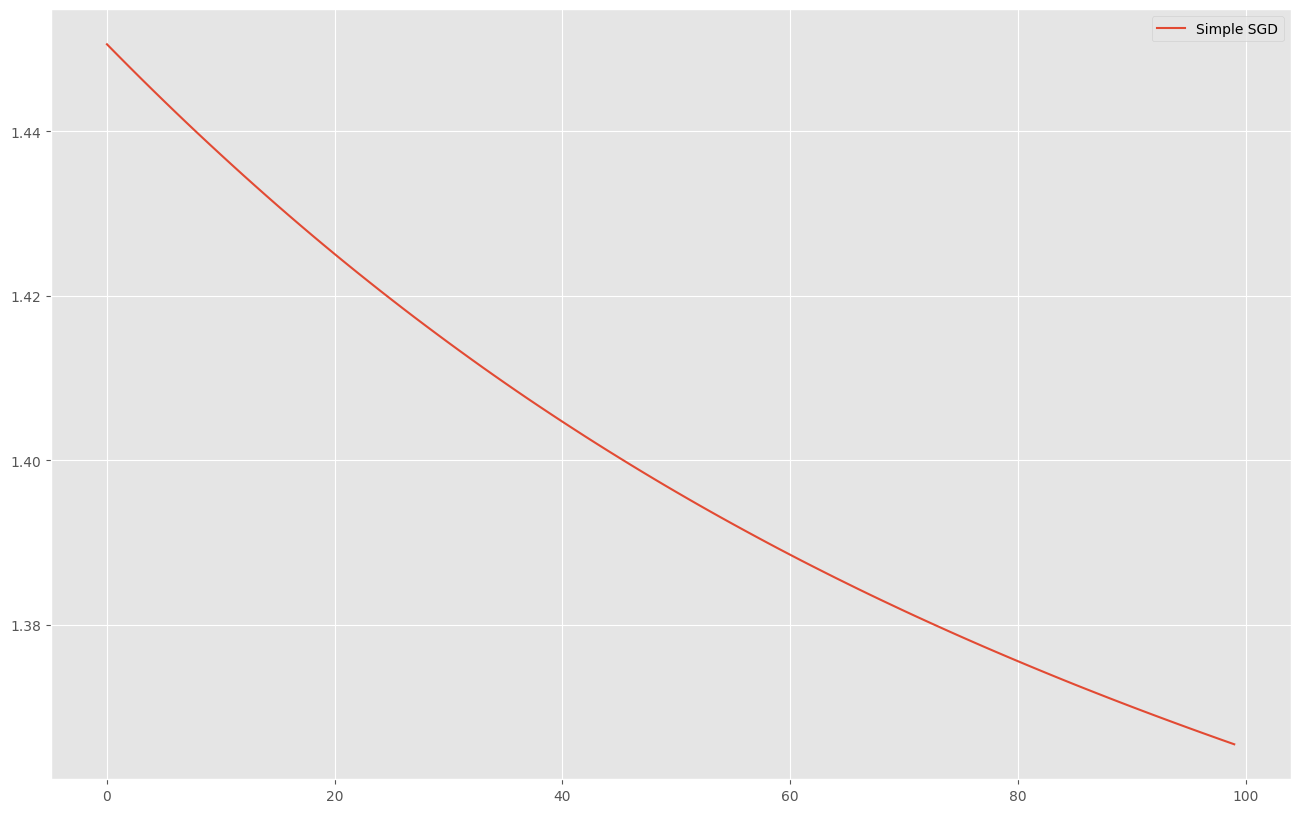

In [13]:
plot([('Simple SGD', valid_loss_values)])

### Nesterov Momentum

In [14]:
# Первая простенькая моделька 
model2 = MyModel()

# инициализируем SGD optimizer
sgd = optim.SGD(model2.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

# запускаем процесс обучения
train_loss_values2, train_accuracy_values2, valid_loss_values2, valid_accuracy2 = run_train(model2, optimizer=sgd, criterion=criterion)

EPOCH 0,  train_loss: 1.400946, valid_accuracy: 0.179098
EPOCH 0, valid_loss: 1.397959, valid_accuracy: 0.178717
EPOCH 20,  train_loss: 1.317688, valid_accuracy: 0.402428
EPOCH 20, valid_loss: 1.316227, valid_accuracy: 0.404994
EPOCH 40,  train_loss: 1.301970, valid_accuracy: 0.403087
EPOCH 40, valid_loss: 1.301354, valid_accuracy: 0.404994
EPOCH 60,  train_loss: 1.295946, valid_accuracy: 0.402794
EPOCH 60, valid_loss: 1.295686, valid_accuracy: 0.404994
EPOCH 80,  train_loss: 1.293187, valid_accuracy: 0.402794
EPOCH 80, valid_loss: 1.292613, valid_accuracy: 0.404994


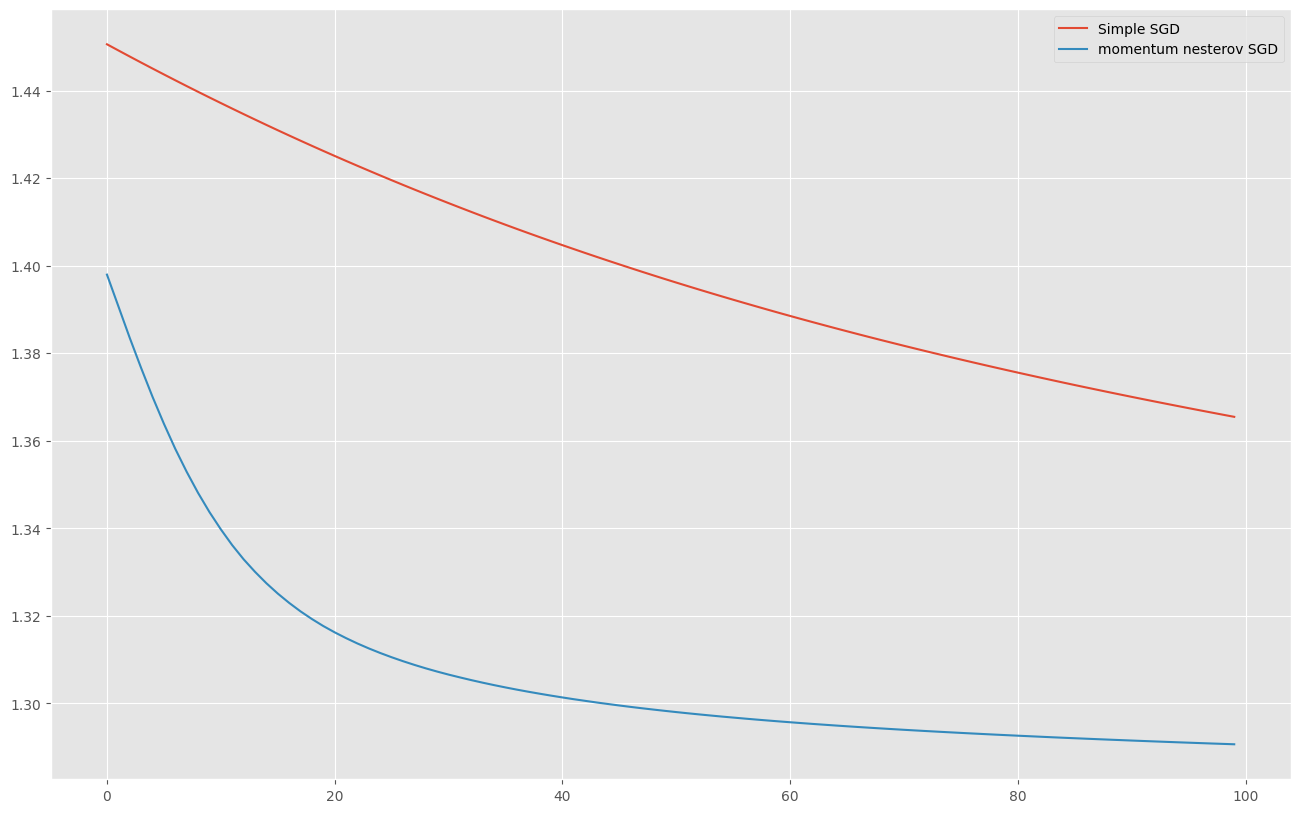

In [15]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2)])


### RMSprop 

In [16]:
# Первая простенькая моделька 
model3 = MyModel()

# инициализируем SGD optimizer
rmsprop = optim.RMSprop(model3.parameters(), lr=LEARNING_RATE, alpha=0.9, eps=1e-08)

# запускаем процесс обучения
train_loss_values3, train_accuracy_values3, valid_loss_values3, valid_accuracy3 = run_train(model3, optimizer=rmsprop, criterion=criterion)

EPOCH 0,  train_loss: 1.345496, valid_accuracy: 0.461678
EPOCH 0, valid_loss: 1.325265, valid_accuracy: 0.531301
EPOCH 20,  train_loss: 1.127270, valid_accuracy: 0.612276
EPOCH 20, valid_loss: 1.132084, valid_accuracy: 0.606729
EPOCH 40,  train_loss: 1.125864, valid_accuracy: 0.613153
EPOCH 40, valid_loss: 1.131179, valid_accuracy: 0.606081
EPOCH 60,  train_loss: 1.111154, valid_accuracy: 0.628607
EPOCH 60, valid_loss: 1.113852, valid_accuracy: 0.624380
EPOCH 80,  train_loss: 1.093819, valid_accuracy: 0.643534
EPOCH 80, valid_loss: 1.100324, valid_accuracy: 0.636565


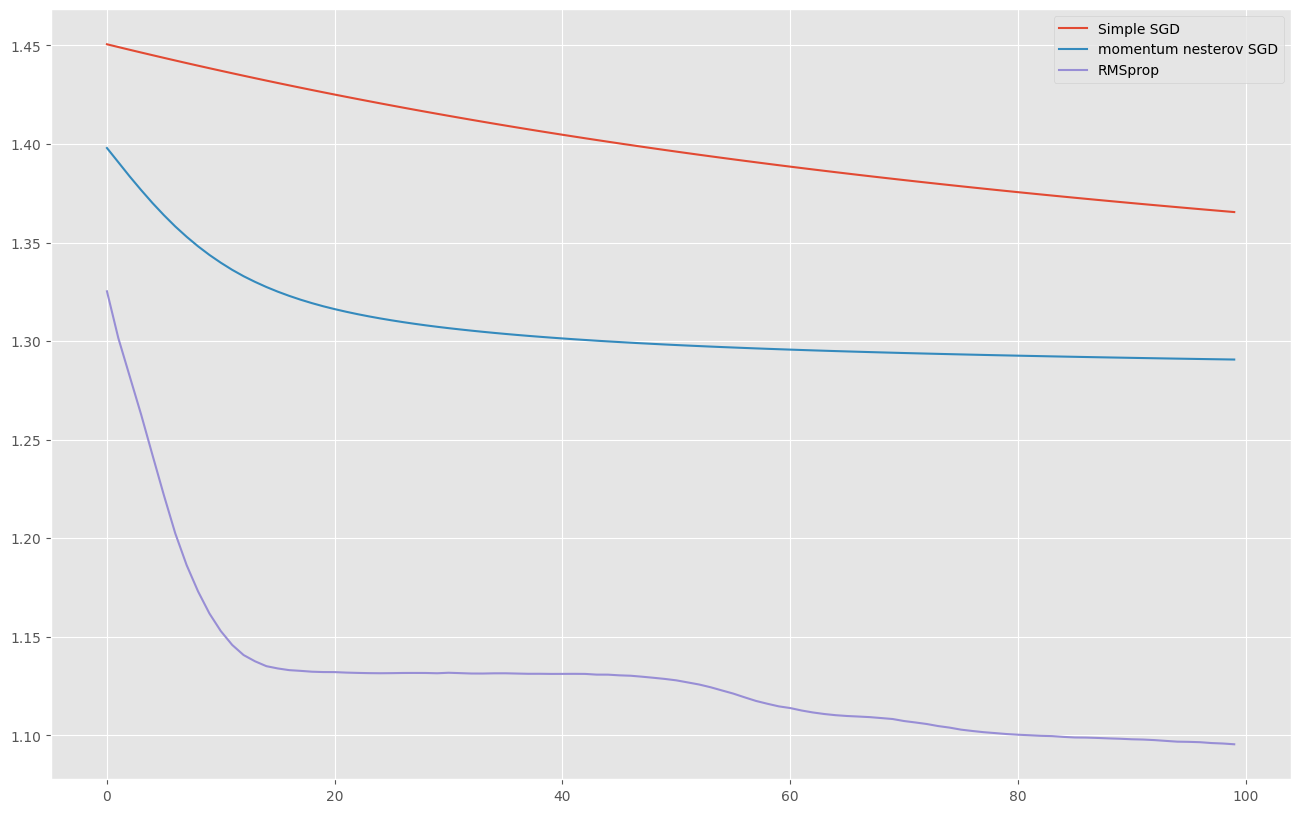

In [17]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3)])

### Adam 

In [18]:
# Первая простенькая моделька 
model4 = MyModel()

# инициализируем SGD optimizer
adam = optim.Adam(model4.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08)

# запускаем процесс обучения
train_loss_values4, train_accuracy_values4, valid_loss_values4, valid_accuracy4 = run_train(model4, optimizer=adam, criterion=criterion)

EPOCH 0,  train_loss: 1.372834, valid_accuracy: 0.349133
EPOCH 0, valid_loss: 1.349796, valid_accuracy: 0.404994
EPOCH 20,  train_loss: 1.132999, valid_accuracy: 0.611347
EPOCH 20, valid_loss: 1.136160, valid_accuracy: 0.605896
EPOCH 40,  train_loss: 1.126818, valid_accuracy: 0.613806
EPOCH 40, valid_loss: 1.132204, valid_accuracy: 0.606729
EPOCH 60,  train_loss: 1.123947, valid_accuracy: 0.616253
EPOCH 60, valid_loss: 1.131030, valid_accuracy: 0.606914
EPOCH 80,  train_loss: 1.123076, valid_accuracy: 0.615062
EPOCH 80, valid_loss: 1.129206, valid_accuracy: 0.606784


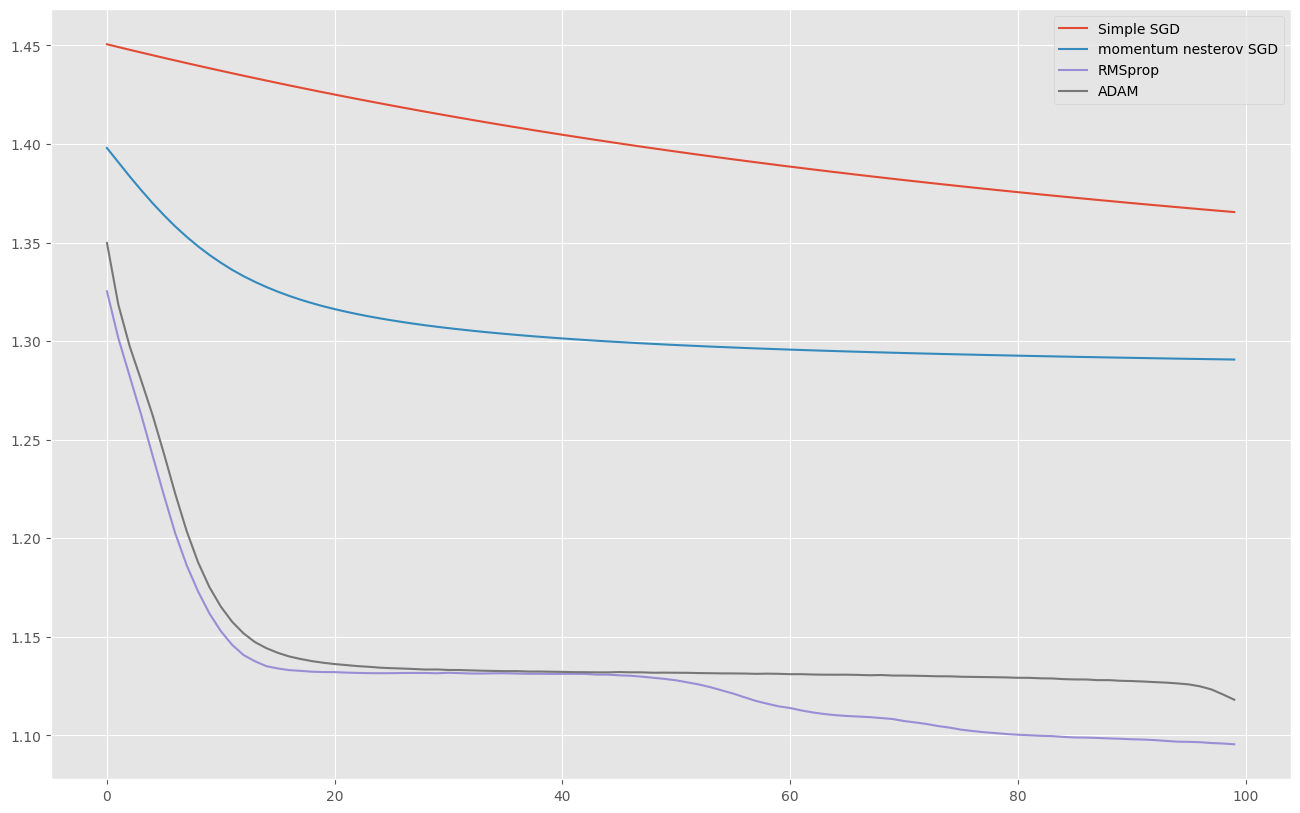

In [19]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4)])


# 4. Стратегии с постепенным понижением lr 


In [20]:
# функция для картинок, чтобы видеть как скорость обучения меняется от эпохи к эпохе
def plot_learning_rate(lr_history):
    fig = plt.figure()
    plt.plot(range(1, EPOCHS+1), lr_history, label='learning rate')
    plt.xlabel("epoch")
    plt.xlim([1, EPOCHS+1])
    plt.ylabel("learning rate")
    plt.legend(loc=0)
    plt.grid(True)
    plt.title("Learning rate")
    plt.show()

Стартовую скорость обучения специально берём большой! 

In [21]:
INIT_LR = 0.1  # устанавливаем lr намеренно большим

In [23]:
model5 = MyModel()

In [ ]:
from torch.optim.lr_scheduler import StepLR

adam = optim.SGD(model5.parameters(), lr=INIT_LR)
scheduler = StepLR(adam, step_size=2, gamma=0.1) # Decays the learning rate of each parameter group by gamma every step_size epochs

for i in range(10):
    print(i + 1, scheduler.get_last_lr())
    scheduler.step()

1 [0.1]
2 [0.1]
3 [0.010000000000000002]
4 [0.010000000000000002]
5 [0.0010000000000000002]
6 [0.0010000000000000002]
7 [0.00010000000000000003]
8 [0.00010000000000000003]
9 [1.0000000000000004e-05]
10 [1.0000000000000004e-05]


In [25]:
len(train_loader)

22

In [26]:
from torch.optim.lr_scheduler import StepLR


# Первая простенькая моделька 
model5 = MyModel()

# инициализируем SGD optimizer
adam = optim.Adam(model5.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)

# инициализируем 
scheduler = StepLR(adam, step_size=50, gamma=0.5)

# запускаем процесс обучения
train_loss_values5, train_accuracy_values5, valid_loss_values5, valid_accuracy5, lr_history5 = run_train(model5, optimizer=adam, 
                                                                                                        criterion=criterion, scheduler=scheduler)

EPOCH 0,  train_loss: 1.172040, valid_accuracy: 0.564067
EPOCH 0, valid_loss: 1.141512, valid_accuracy: 0.601563
EPOCH 20,  train_loss: 1.108110, valid_accuracy: 0.630100
EPOCH 20, valid_loss: 1.123752, valid_accuracy: 0.611656
EPOCH 40,  train_loss: 1.093360, valid_accuracy: 0.645698
EPOCH 40, valid_loss: 1.118140, valid_accuracy: 0.619843
EPOCH 60,  train_loss: 1.077960, valid_accuracy: 0.662665
EPOCH 60, valid_loss: 1.116321, valid_accuracy: 0.620119
EPOCH 80,  train_loss: 1.039824, valid_accuracy: 0.702195
EPOCH 80, valid_loss: 1.090692, valid_accuracy: 0.646030


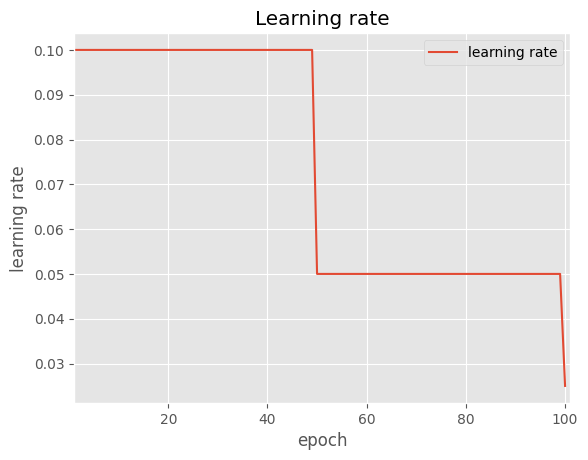

In [27]:
# Смотрим как скорость обучения по-немногу понижалась
plot_learning_rate(lr_history5)

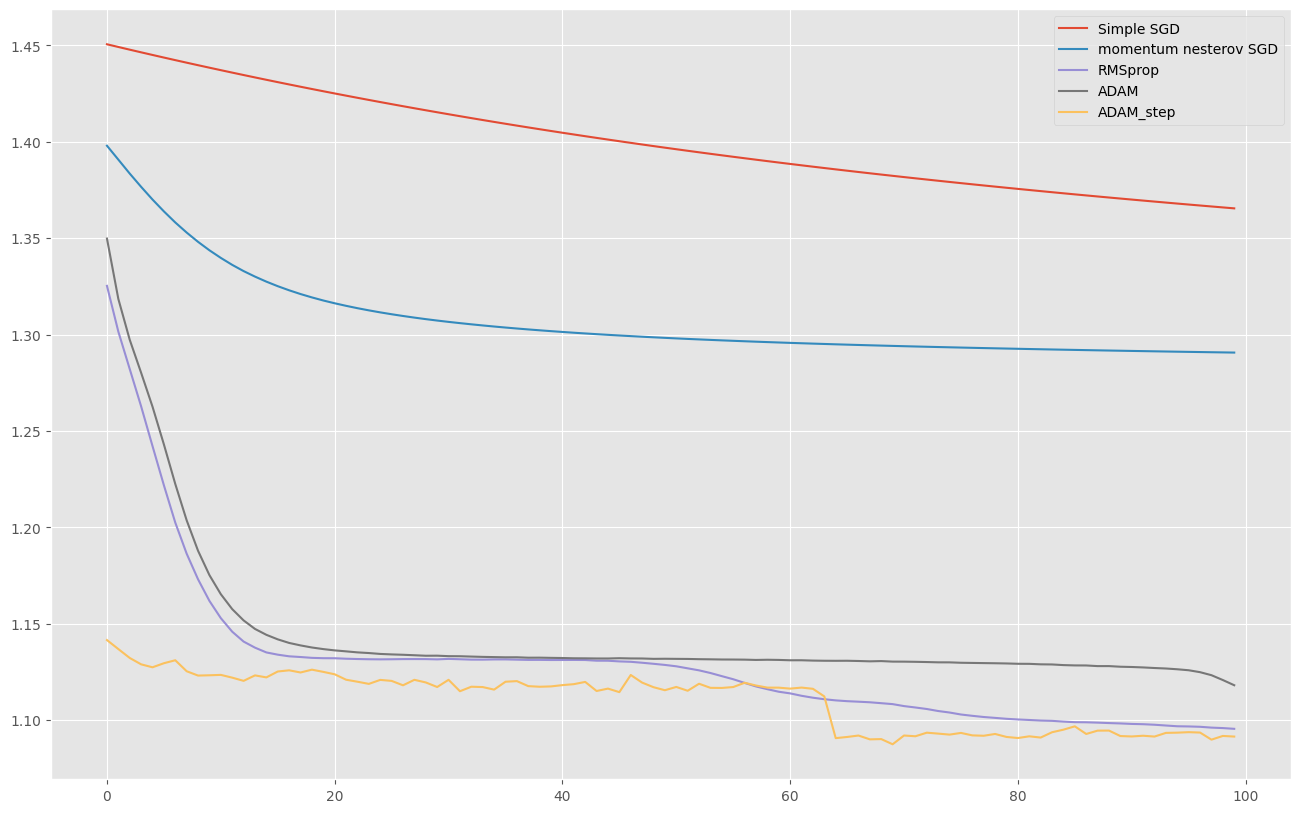

In [28]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5)])

Попробуем ещё вариант!

In [29]:
from torch.optim.lr_scheduler import MultiStepLR


# Первая простенькая моделька 
model6 = MyModel()

# инициализируем SGD optimizer
adam = optim.Adam(model6.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)

# инициализируем 
scheduler = MultiStepLR(adam, milestones=[30,80], gamma=0.1) # Decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones

# запускаем процесс обучения
train_loss_values6, train_accuracy_values6, valid_loss_values6, valid_accuracy6, lr_history6 = run_train(model6, optimizer=adam, 
                                                                                                        criterion=criterion, scheduler=scheduler)

EPOCH 0,  train_loss: 1.184752, valid_accuracy: 0.544993
EPOCH 0, valid_loss: 1.137919, valid_accuracy: 0.604471
EPOCH 20,  train_loss: 1.103104, valid_accuracy: 0.635145
EPOCH 20, valid_loss: 1.120142, valid_accuracy: 0.615304
EPOCH 40,  train_loss: 1.086525, valid_accuracy: 0.657145
EPOCH 40, valid_loss: 1.121718, valid_accuracy: 0.614434
EPOCH 60,  train_loss: 1.080625, valid_accuracy: 0.663675
EPOCH 60, valid_loss: 1.121663, valid_accuracy: 0.615638
EPOCH 80,  train_loss: 1.077698, valid_accuracy: 0.666895
EPOCH 80, valid_loss: 1.122449, valid_accuracy: 0.616619


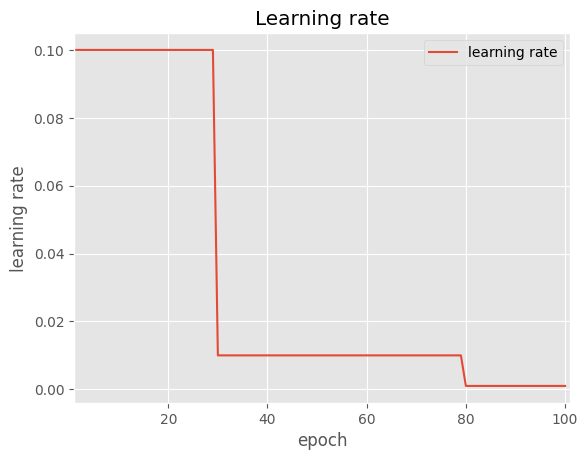

In [30]:
# Смотрим как скорость обучения по немного понижалась
plot_learning_rate(lr_history6)

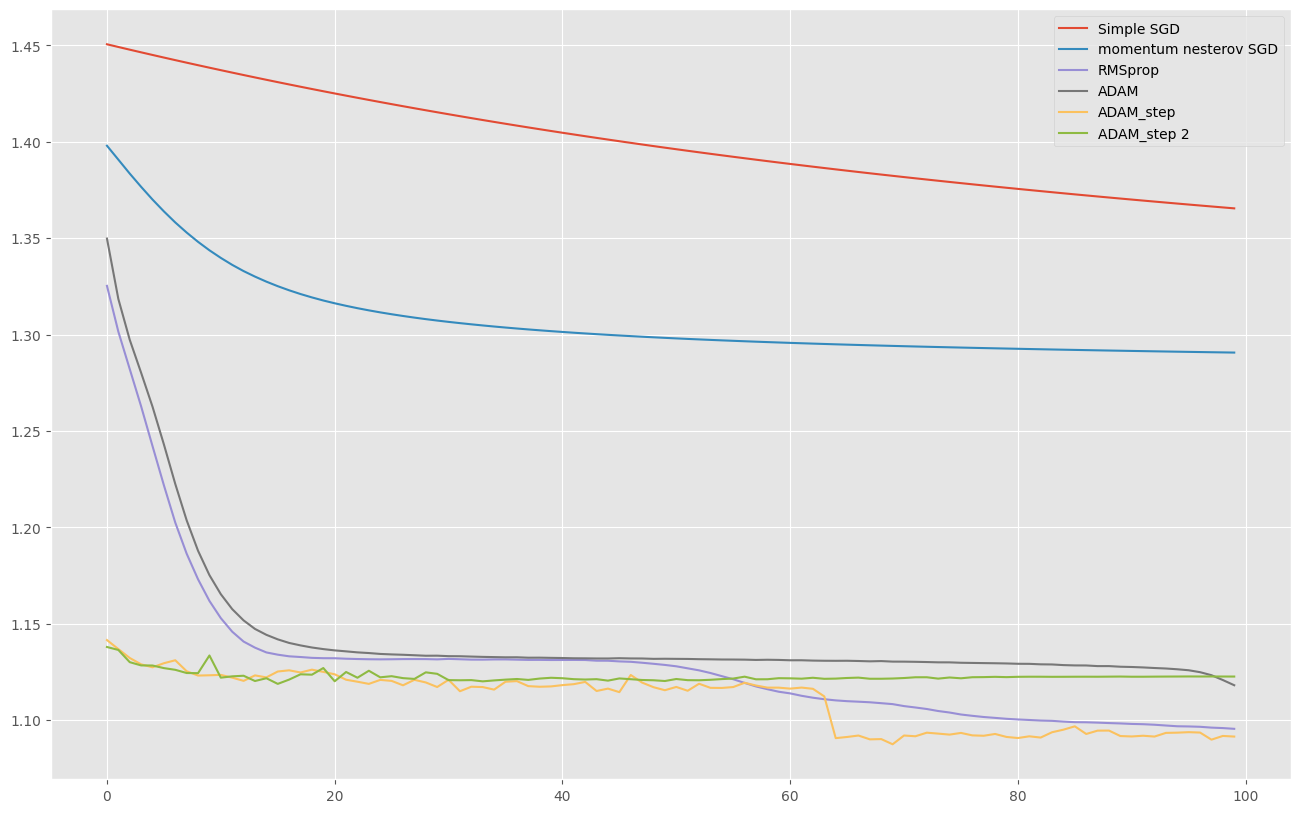

In [31]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5),
      ('ADAM_step 2', valid_loss_values6)])

Существует множество различных Scheduler`ов. Полный список можно найти на [странице](https://pytorch.org/docs/stable/optim.html) в разделе "How to adjust learning rate"

Великолепное описание различных Scheduler`ов и как их применять можно найти по [ссылке](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/)

## Авторские права и почиташки 

* Для создания тетрадки использовался [вот этот мануал](https://github.com/sukilau/Ziff-deep-learning/blob/master/3-CIFAR10-lrate/CIFAR10-lrate.ipynb), адаптированный под PyTorch

##   Поиграться при желании
Пришло время заняться исследованиями! На лекции мы с вами обсудили, что сегодня люди ставят довольно большое число разных экспериментов с циклической скоростью обучения. Делают они это, чтобы как-то соскальзывать с сёдел и выбираться из локальных минимумов.  В этом задании вам надо будет немного поэкспериментировать с такими скоростями обучения. Предлагается поизучать [Scheduler`ы](https://pytorch.org/docs/stable/optim.html), реализованные в PyTorch и выбрать 2-3 для сравнения с рассмотренными вариантами на семинаре

Вообще поощряются любые эксперименты. Не забывайте строить картинки. Можете как-то видоизменить архитектуру сетки. Например, добавить какие-то новые слои или сделать её глубже. Эксперименты можно оформлять прямо в этой тетрадке. Её же и присылайте.

Если хочется вдохновения, [в этой статье](https://www.jeremyjordan.me/nn-learning-rate/) можно найти много разных вариантов пересчёта скорости обучения. Есть варианты с циклами и даже косинусами! Единственное, что код в статье написан на Keras, но это никак не мешает изучить суть алгоритмов. Еще одна полезная [ссылка](https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/).

Плодотворных экспериментов :) 

In [74]:
# буду использовать ту же модель с теми же параметрами и менять learning rate
INIT_LR = 0.001

#### CyclicLR

Как я поняла: указываются границы для lr (начальный и максимальный), и во время обучения значения lr меняются в этих пределах в циклах. Циклы могут быть разные: они состоят из повышения и понижения lr, снижение может проходить с разной амплитудой (на какое-то фиксированное число или, например, экспоненциально)

In [75]:
model7 = MyModel()
optimizer = optim.Adam(model7.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)
criterion = nn.CrossEntropyLoss()

In [ ]:
from torch.optim.lr_scheduler import CyclicLR

scheduler = CyclicLR(optimizer, base_lr=INIT_LR, max_lr=0.1, mode='triangular2') # “triangular2”: A basic triangular cycle that scales initial amplitude by half each cycle
# будем шагать между 0.001 и 0.1

In [77]:
# запускаем процесс обучения
train_loss_values7, train_accuracy_values7, valid_loss_values7, valid_accuracy7, lr_history7 = run_train(model7, optimizer=optimizer,
                                                                                                    criterion=criterion, scheduler=scheduler)

EPOCH 0,  train_loss: 1.369951, valid_accuracy: 0.302608
EPOCH 0, valid_loss: 1.347927, valid_accuracy: 0.352322
EPOCH 20,  train_loss: 1.127597, valid_accuracy: 0.614105
EPOCH 20, valid_loss: 1.133369, valid_accuracy: 0.606859
EPOCH 40,  train_loss: 1.124816, valid_accuracy: 0.614009
EPOCH 40, valid_loss: 1.130438, valid_accuracy: 0.605933
EPOCH 60,  train_loss: 1.094816, valid_accuracy: 0.643928
EPOCH 60, valid_loss: 1.099274, valid_accuracy: 0.640418
EPOCH 80,  train_loss: 1.071514, valid_accuracy: 0.669377
EPOCH 80, valid_loss: 1.083907, valid_accuracy: 0.655566


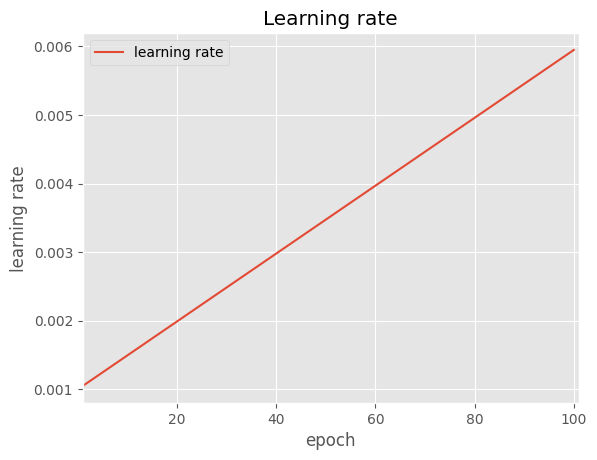

In [78]:
plot_learning_rate(lr_history7)

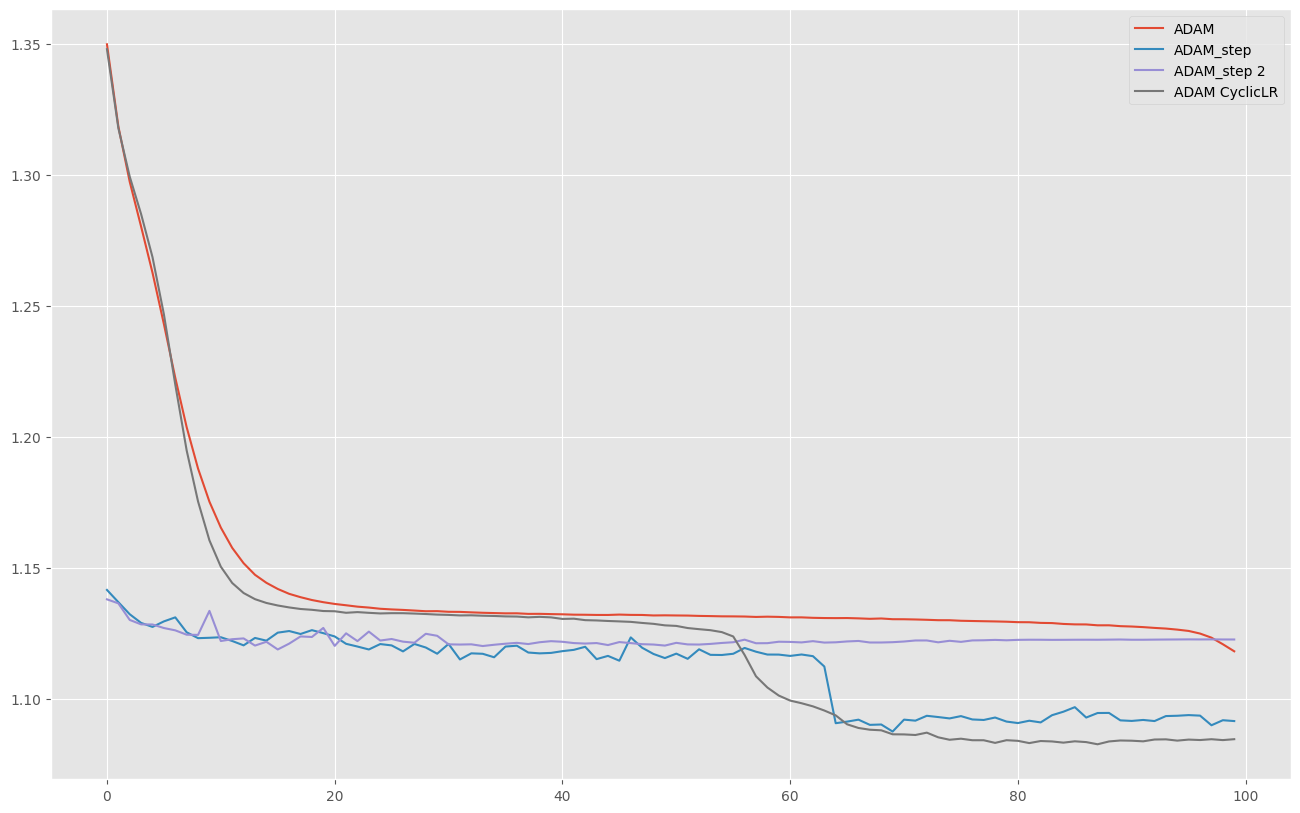

In [79]:
plot([('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5),
      ('ADAM_step 2', valid_loss_values6),
      ('ADAM CyclicLR', valid_loss_values7)])

Я так понимаю, что по этому графику можно посмотреть, на какой эпохе ошибка заметно снижалась и потом была стабильной (например, на 70 эпохе). По графику, отображающему изменение lr, можно посмотреть, какой lr был на 70 эпохе. Вероятно, это и есть оптимальный lr.

С этим scheduler качество стало лучше!

#### ExponentialLR

In [80]:
INIT_LR = 0.1

model8 = MyModel()
optimizer = optim.Adam(model8.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)

In [81]:
from torch.optim.lr_scheduler import ExponentialLR

scheduler = ExponentialLR(optimizer, gamma=0.9) # Decays the learning rate of each parameter group by gamma every epoch

In [82]:
# запускаем процесс обучения
train_loss_values8, train_accuracy_values8, valid_loss_values8, valid_accuracy8, lr_history8 = run_train(model8, optimizer=optimizer,
                                                                                                    criterion=criterion, scheduler=scheduler)

EPOCH 0,  train_loss: 1.179080, valid_accuracy: 0.546445
EPOCH 0, valid_loss: 1.137984, valid_accuracy: 0.604693
EPOCH 20,  train_loss: 1.096740, valid_accuracy: 0.641711
EPOCH 20, valid_loss: 1.116978, valid_accuracy: 0.616341
EPOCH 40,  train_loss: 1.090522, valid_accuracy: 0.649498
EPOCH 40, valid_loss: 1.117693, valid_accuracy: 0.616304
EPOCH 60,  train_loss: 1.090462, valid_accuracy: 0.649905
EPOCH 60, valid_loss: 1.117578, valid_accuracy: 0.616989
EPOCH 80,  train_loss: 1.090918, valid_accuracy: 0.649264
EPOCH 80, valid_loss: 1.117575, valid_accuracy: 0.616989


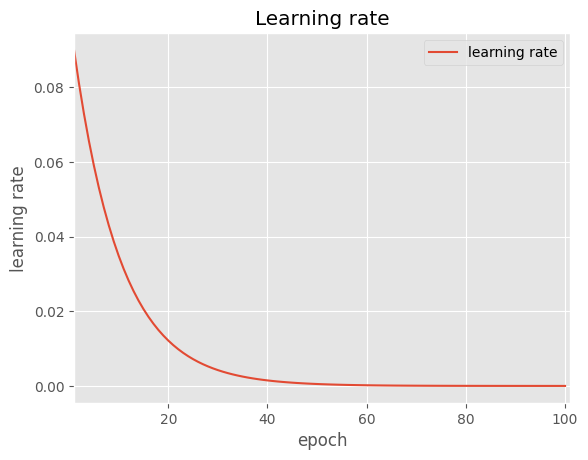

In [83]:
plot_learning_rate(lr_history8)

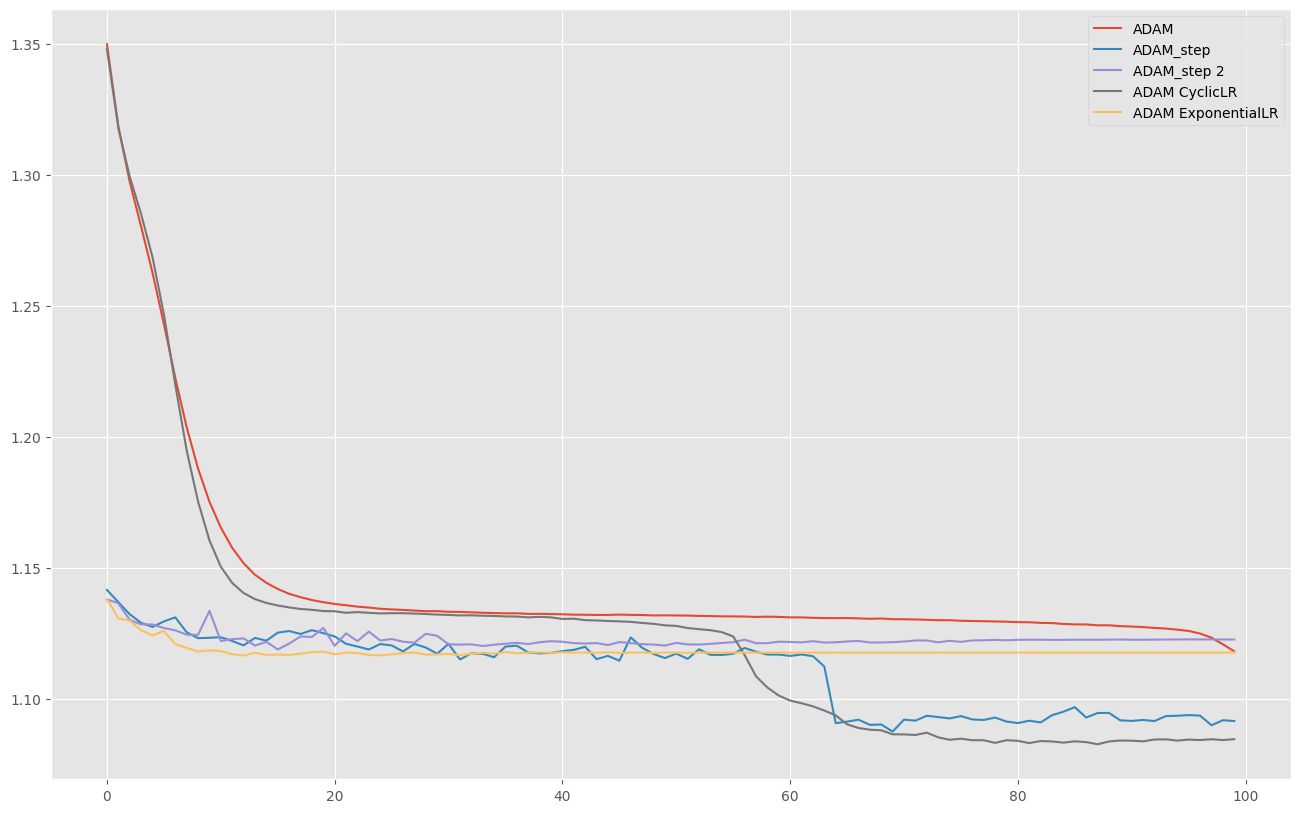

In [84]:
plot([('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5),
      ('ADAM_step 2', valid_loss_values6),
      ('ADAM CyclicLR', valid_loss_values7),
      ('ADAM ExponentialLR', valid_loss_values8)])

#### ConstantLR

In [89]:
INIT_LR = 0.1

model9 = MyModel()
optimizer = optim.Adam(model9.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)

In [90]:
from torch.optim.lr_scheduler import ConstantLR

scheduler = ConstantLR(optimizer, factor=0.3333333333, total_iters=99) # Multiply the learning rate of each parameter group by a small constant factor
                                                              # The multiplication is done until the number of epoch reaches a pre-defined milestone: total_iters.
                                                              # When last_epoch=-1, sets initial lr as lr

In [91]:
# запускаем процесс обучения
train_loss_values9, train_accuracy_values9, valid_loss_values9, valid_accuracy9, lr_history9 = run_train(model9, optimizer=optimizer,
                                                                                                    criterion=criterion, scheduler=scheduler)

EPOCH 0,  train_loss: 1.213729, valid_accuracy: 0.520458
EPOCH 0, valid_loss: 1.136480, valid_accuracy: 0.604378
EPOCH 20,  train_loss: 1.066079, valid_accuracy: 0.673317
EPOCH 20, valid_loss: 1.086170, valid_accuracy: 0.651845
EPOCH 40,  train_loss: 1.046474, valid_accuracy: 0.694274
EPOCH 40, valid_loss: 1.094897, valid_accuracy: 0.644270
EPOCH 60,  train_loss: 1.035027, valid_accuracy: 0.708155
EPOCH 60, valid_loss: 1.093094, valid_accuracy: 0.645325
EPOCH 80,  train_loss: 1.028818, valid_accuracy: 0.714276
EPOCH 80, valid_loss: 1.092235, valid_accuracy: 0.649288


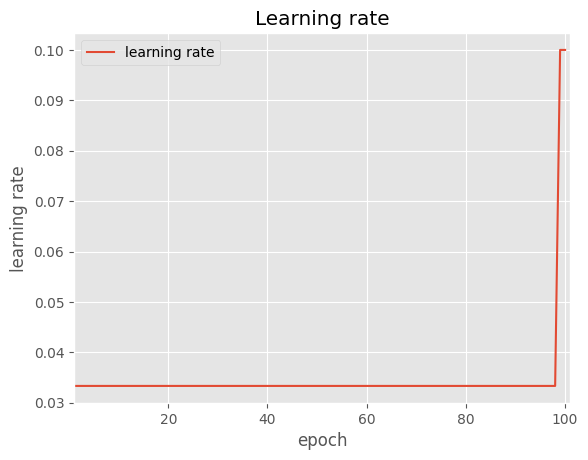

In [92]:
plot_learning_rate(lr_history9)

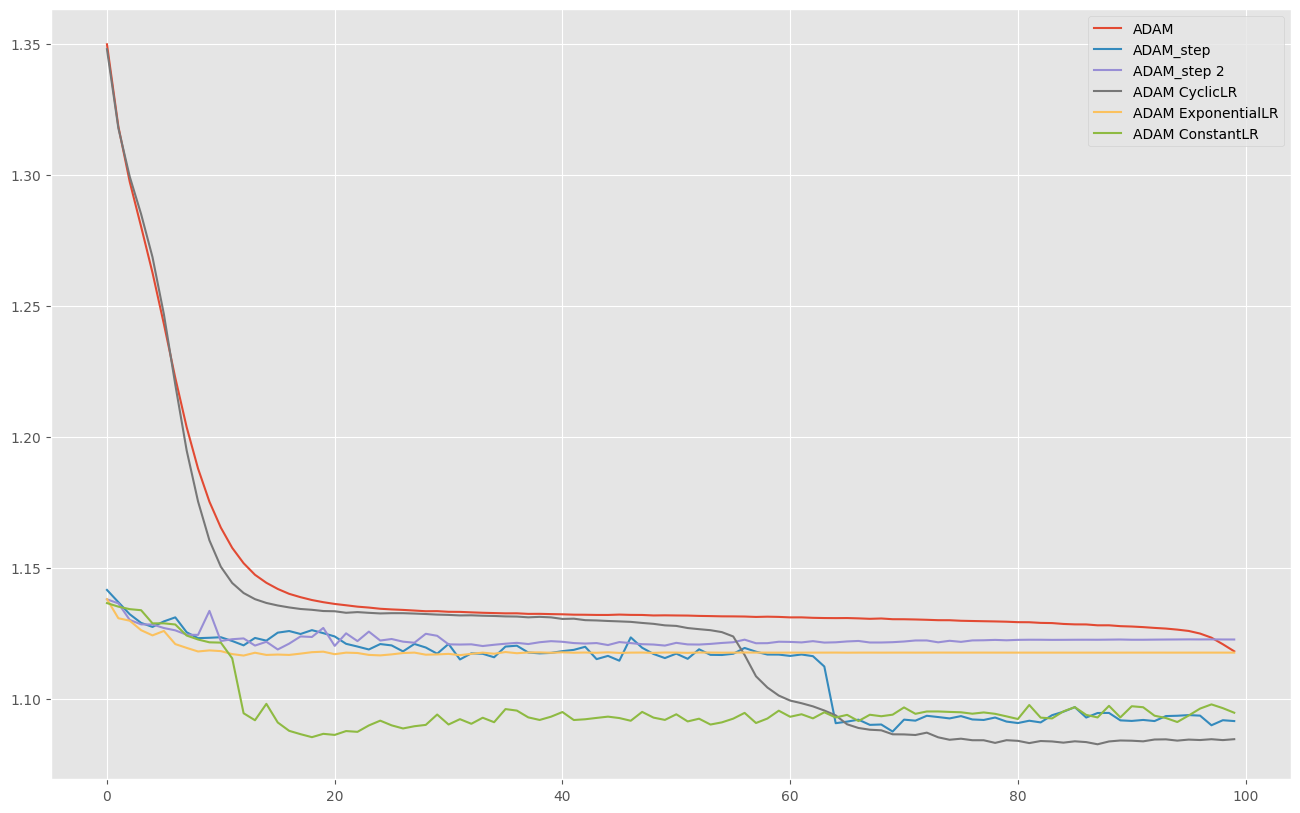

: 

In [ ]:
plot([('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5),
      ('ADAM_step 2', valid_loss_values6),
      ('ADAM CyclicLR', valid_loss_values7),
      ('ADAM ExponentialLR', valid_loss_values8),
      ('ADAM ConstantLR', valid_loss_values9)])

Не совсем поняла, как работает ExponentialLR; по результатам как будто бы больше понравился CyclicLR